In [0]:
#Importing the necessary libraries

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType
from pyspark.sql.types import *
from pyspark.sql.functions import col 
from pyspark.sql.functions import to_date
from pyspark.sql.functions import lit
from pyspark.sql.functions import sum, avg, max, min, mean, count
from pyspark.sql.functions import *
from datetime import datetime, date
import pandas as pd
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.types import TimestampType
from pyspark.sql import functions as F
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

# Facebook Prophet Model
%pip install pystan==2.19.1.1 
%pip install fbprophet
from fbprophet import Prophet

In [0]:
# Amazon S3 file paths to retrieve teh stored data

path='s3a://just-abdul-aws/NTA/Yellow_Taxi_Trip_Data_2020.csv'
path_location='s3a://just-abdul-aws/NTA/taxi_zones.csv'

In [0]:
# Reading the data

df = spark.read.csv(path, header=True, inferSchema=True)
df_location = spark.read.csv(path_location, header=True, inferSchema=True)

In [0]:
df.limit(5).display()
df_location.limit(5).display()

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
1,01/01/2020 12:28:15 AM,01/01/2020 12:33:03 AM,1,1.2,1,N,238,239,1,6,3,0.5,1.47,0.0,0.3,11.27,2.5
1,01/01/2020 12:35:39 AM,01/01/2020 12:43:04 AM,1,1.2,1,N,239,238,1,7,3,0.5,1.5,0.0,0.3,12.3,2.5
1,01/01/2020 12:47:41 AM,01/01/2020 12:53:52 AM,1,0.6,1,N,238,238,1,6,3,0.5,1,0.0,0.3,10.8,2.5
1,01/01/2020 12:55:23 AM,01/01/2020 01:00:14 AM,1,0.8,1,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
2,01/01/2020 12:01:58 AM,01/01/2020 12:04:16 AM,1,0,1,N,193,193,2,3.5,0.5,0.5,0,0.0,0.3,4.8,0.0


X,Y,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough
-74.1767857452143,40.6895156480431,1,0.116357453189,7.823067885E-4,Newark Airport,1,EWR
-73.8261257703202,40.6257242377511,2,0.43346966679,0.00486634037837,Jamaica Bay,2,Queens
-73.8494789238597,40.8658875419774,3,0.0843411059012,3.14414156821E-4,Allerton/Pelham Gardens,3,Bronx
-73.9770229219339,40.7241521436714,4,0.0435665270921,1.11871946192E-4,Alphabet City,4,Manhattan
-74.1899296712375,40.550340123832,5,0.0921464898574,4.97957489363E-4,Arden Heights,5,Staten Island


In [0]:
# To check if the Location ID's for the Trip data (Pick Up, Drop Off) and the Location data matches

loc_count = df_location.select('LocationID').distinct().count()
PU_count = df.select('PULocationID').distinct().count()
DO_count = df.select('DOLocationID').distinct().count()

In [0]:
print("The location data has: " + str(loc_count) + " distinct Location ID's")
print("Pick Up Location has: " + str(PU_count) + " distinct Location ID's")
print("Drop Off location data has: " + str(DO_count) + " distinct Location ID's")

The location data has: 260 distinct Location ID's
Pick Up Location has: 262 distinct Location ID's
Drop Off location data has: 263 distinct Location ID's

In [0]:
%%time

location = df_location.select("LocationID","zone","borough")
PU_location = location.withColumnRenamed("LocationID","PULocationID")
DO_location = location.withColumnRenamed("LocationID","DOLocationID")

PU_data = df.join(PU_location, "PULocationID", 'left')
PU_data = PU_data.withColumnRenamed("zone","PU_Zone")
PU_data = PU_data.withColumnRenamed("borough","PU_Borough")

data = PU_data.join(DO_location, "DOLocationID", 'left')
data = data.withColumnRenamed("zone","DO_Zone")
data = data.withColumnRenamed("borough","DO_Borough")

CPU times: user 2.15 ms, sys: 3.57 ms, total: 5.73 ms
Wall time: 56.2 ms

In [0]:
data = data.withColumnRenamed("trip_distance","trip_distance(miles)")

In [0]:
# Peak-up timestamp

data = data.withColumn("PU_timestamp", from_unixtime(unix_timestamp("tpep_pickup_datetime", 'MM/dd/yyyy hh:mm:ss a')).cast(TimestampType()))

In [0]:
# Drop-Off timestamp

data = data.withColumn("DO_timestamp", from_unixtime(unix_timestamp("tpep_dropoff_datetime", 'MM/dd/yyyy hh:mm:ss a')).cast(TimestampType()))

In [0]:
data = data.withColumn("Year", year(col("DO_timestamp")))

In [0]:
data = data.filter(data["Year"] == 2020) # Filtering to ensure that the dataset is for year 2020. Filtering-out all dropoffs that are not 2020. 

In [0]:
# Changing the data type from String to Double

data = data.withColumn("trip_distance(miles)", col("trip_distance(miles)").cast('double'))
data = data.withColumn("fare_amount", col("fare_amount").cast('double'))
data = data.withColumn("mta_tax", col("mta_tax").cast('double'))
data = data.withColumn("tip_amount", col("tip_amount").cast('double'))
data = data.withColumn("total_amount", col("total_amount").cast('double'))
data = data.withColumn("extra", col("extra").cast('double'))

In [0]:
%%time
data.limit(5).display()

DOLocationID,PULocationID,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance(miles),RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,PU_Zone,PU_Borough,DO_Zone,DO_Borough,PU_timestamp,DO_timestamp,Year
239,238,1,01/01/2020 12:28:15 AM,01/01/2020 12:33:03 AM,1,1.2,1,N,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,Upper West Side North,Manhattan,Upper West Side South,Manhattan,2020-01-01T00:28:15.000+0000,2020-01-01T00:33:03.000+0000,2020
238,239,1,01/01/2020 12:35:39 AM,01/01/2020 12:43:04 AM,1,1.2,1,N,1,7.0,3.0,0.5,1.5,0.0,0.3,12.3,2.5,Upper West Side South,Manhattan,Upper West Side North,Manhattan,2020-01-01T00:35:39.000+0000,2020-01-01T00:43:04.000+0000,2020
238,238,1,01/01/2020 12:47:41 AM,01/01/2020 12:53:52 AM,1,0.6,1,N,1,6.0,3.0,0.5,1.0,0.0,0.3,10.8,2.5,Upper West Side North,Manhattan,Upper West Side North,Manhattan,2020-01-01T00:47:41.000+0000,2020-01-01T00:53:52.000+0000,2020
151,238,1,01/01/2020 12:55:23 AM,01/01/2020 01:00:14 AM,1,0.8,1,N,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,Upper West Side North,Manhattan,Manhattan Valley,Manhattan,2020-01-01T00:55:23.000+0000,2020-01-01T01:00:14.000+0000,2020
193,193,2,01/01/2020 12:01:58 AM,01/01/2020 12:04:16 AM,1,0.0,1,N,2,3.5,0.5,0.5,0.0,0.0,0.3,4.8,0.0,Queensbridge/Ravenswood,Queens,Queensbridge/Ravenswood,Queens,2020-01-01T00:01:58.000+0000,2020-01-01T00:04:16.000+0000,2020


CPU times: user 686 µs, sys: 230 µs, total: 916 µs
Wall time: 4.9 ms

In [0]:
# Dropping all null values

data = data.dropna()

In [0]:
data.count()

Out[29]: 23584156

# Data Mining

# Pickup zone 

In [0]:
# Top pick up locations

PU_Count = data.groupBy("PU_Zone", "PU_Borough").agg(count("*").alias("Count"))
PU_Count = PU_Count.sort(PU_Count.Count.desc()).limit(10)
PU_Count.display()

PU_Zone,PU_Borough,Count
Upper East Side South,Manhattan,1133820
Upper East Side North,Manhattan,1076788
Midtown Center,Manhattan,937834
Penn Station/Madison Sq West,Manhattan,854699
Midtown East,Manhattan,823764
Murray Hill,Manhattan,741236
Lincoln Square East,Manhattan,737805
Clinton East,Manhattan,719594
Upper West Side South,Manhattan,695903
Times Sq/Theatre District,Manhattan,680501


In [0]:
# Least pick up locations

PU_Count = data.groupBy("PU_Zone", "PU_Borough").agg(count("*").alias("Count"))
PU_Count = PU_Count.sort(PU_Count.Count.asc()).limit(10)
PU_Count.display()

PU_Zone,PU_Borough,Count
West Brighton,Staten Island,6
Rikers Island,Bronx,7
Broad Channel,Queens,7
Oakwood,Staten Island,9
Breezy Point/Fort Tilden/Riis Beach,Queens,14
Green-Wood Cemetery,Brooklyn,15
Jamaica Bay,Queens,19
Eltingville/Annadale/Prince's Bay,Staten Island,21
Westerleigh,Staten Island,25
Port Richmond,Staten Island,27


# Top Drop Off Location

In [0]:
# Top Drop Off locations

DO_Count = data.groupBy("DO_Zone","DO_Borough").agg(count("*").alias("Count"))
DO_Count = DO_Count.sort(DO_Count.Count.desc()).limit(10)
DO_Count.display()

DO_Zone,DO_Borough,Count
Upper East Side North,Manhattan,1113516
Upper East Side South,Manhattan,1005043
Midtown Center,Manhattan,835940
Murray Hill,Manhattan,727413
Lenox Hill West,Manhattan,678355
Lincoln Square East,Manhattan,662322
Upper West Side South,Manhattan,660114
Midtown East,Manhattan,659422
Clinton East,Manhattan,631986
Upper West Side North,Manhattan,598618


In [0]:
# Least Drop Off Locations

DO_Count = data.groupBy("DO_Zone","DO_Borough").agg(count("*").alias("Count"))
DO_Count = DO_Count.sort(DO_Count.Count.asc()).limit(10)
DO_Count.display()

DO_Zone,DO_Borough,Count
Rikers Island,Bronx,2
Jamaica Bay,Queens,18
Freshkills Park,Staten Island,114
Broad Channel,Queens,120
Rossville/Woodrow,Staten Island,146
Port Richmond,Staten Island,161
Eltingville/Annadale/Prince's Bay,Staten Island,181
Oakwood,Staten Island,195
Crotona Park,Bronx,209
Breezy Point/Fort Tilden/Riis Beach,Queens,239


1) Top Pick Up and Drop Off locations = Upper East Side North and Upper East Side South (All the top PU and DO spots are in Manhattan)

2) Least Pick Up location = West Brighton and Rikers Island (least PU and DO spots are in Queens, Bronx and Staten Island)

In [0]:
# Top distance travelled

trip_distance = data.select(["trip_distance(miles)", "tpep_pickup_datetime", "tpep_dropoff_datetime", "PU_Zone", "DO_Zone"]).sort(data["trip_distance(miles)"].desc()).limit(10)
trip_distance.display()

trip_distance(miles),tpep_pickup_datetime,tpep_dropoff_datetime,PU_Zone,DO_Zone
516.73,11/27/2020 10:06:33 PM,11/27/2020 10:10:02 PM,Sutton Place/Turtle Bay North,Sutton Place/Turtle Bay North
358.33,09/09/2020 04:07:59 AM,09/09/2020 08:14:26 PM,Penn Station/Madison Sq West,East Concourse/Concourse Village
341.26,11/27/2020 06:17:13 PM,11/27/2020 06:21:21 PM,West Village,East Chelsea
277.8,11/13/2020 09:07:06 AM,11/13/2020 07:54:17 PM,East Village,Alphabet City
274.5,02/12/2020 11:36:07 AM,02/12/2020 05:43:11 PM,Clinton East,Garment District
265.1,12/08/2020 07:01:07 PM,12/09/2020 12:30:36 AM,Times Sq/Theatre District,Marine Park/Mill Basin
257.0,07/15/2020 02:53:31 PM,07/15/2020 08:55:13 PM,Prospect Heights,Canarsie
240.7,06/25/2020 10:38:30 AM,06/25/2020 04:09:21 PM,Penn Station/Madison Sq West,Queens Village
238.0,05/07/2020 07:27:43 AM,05/07/2020 02:13:53 PM,Penn Station/Madison Sq West,Marine Park/Mill Basin
226.6,03/08/2020 01:49:56 PM,03/08/2020 07:29:33 PM,East Harlem North,Brooklyn Heights


For the trip with 516.73 miles, its travel time (drop off - pick up) was 4 minutes and for all the other trips exceeding 200miles, the least travel time was more than 6hours, indicating an error in the record, and thus the row will be filtered out. 

In [0]:
#Filtering out the row

data = data.filter(data["trip_distance(miles)"] != 516.73)

In [0]:
# longest trip distance

trip_distance = data.select(["trip_distance(miles)", "tpep_pickup_datetime", "tpep_dropoff_datetime", "PU_Zone", "DO_Zone"]).sort(data["trip_distance(miles)"].desc()).limit(10)
trip_distance.display()

trip_distance(miles),tpep_pickup_datetime,tpep_dropoff_datetime,PU_Zone,DO_Zone
358.33,09/09/2020 04:07:59 AM,09/09/2020 08:14:26 PM,Penn Station/Madison Sq West,East Concourse/Concourse Village
341.26,11/27/2020 06:17:13 PM,11/27/2020 06:21:21 PM,West Village,East Chelsea
277.8,11/13/2020 09:07:06 AM,11/13/2020 07:54:17 PM,East Village,Alphabet City
274.5,02/12/2020 11:36:07 AM,02/12/2020 05:43:11 PM,Clinton East,Garment District
265.1,12/08/2020 07:01:07 PM,12/09/2020 12:30:36 AM,Times Sq/Theatre District,Marine Park/Mill Basin
257.0,07/15/2020 02:53:31 PM,07/15/2020 08:55:13 PM,Prospect Heights,Canarsie
240.7,06/25/2020 10:38:30 AM,06/25/2020 04:09:21 PM,Penn Station/Madison Sq West,Queens Village
238.0,05/07/2020 07:27:43 AM,05/07/2020 02:13:53 PM,Penn Station/Madison Sq West,Marine Park/Mill Basin
226.6,03/08/2020 01:49:56 PM,03/08/2020 07:29:33 PM,East Harlem North,Brooklyn Heights
223.7,05/01/2020 07:03:22 PM,05/01/2020 07:03:31 PM,Flatlands,Flatlands


In [0]:
# Filtering out the trip distance column to ensure only positive (+ve) numbers.

data = data.filter(data["trip_distance(miles)"] >= 0.0)

In [0]:
# least distance travelled

trip_distance = data.select(["trip_distance(miles)", "fare_amount", "tpep_pickup_datetime", "tpep_dropoff_datetime", "PU_Zone", "DO_Zone"]).sort(data["trip_distance(miles)"].asc()).limit(10)
trip_distance.display()

trip_distance(miles),fare_amount,tpep_pickup_datetime,tpep_dropoff_datetime,PU_Zone,DO_Zone
0.0,17.2,03/10/2020 11:06:56 AM,03/10/2020 11:25:13 AM,Lincoln Square West,Union Sq
0.0,15.0,03/10/2020 11:43:03 AM,03/10/2020 11:43:30 AM,Union Sq,Union Sq
0.0,28.2,03/10/2020 11:22:29 AM,03/10/2020 11:56:36 AM,Kingsbridge Heights,Lenox Hill East
0.0,60.0,03/10/2020 11:15:52 AM,03/10/2020 11:16:00 AM,West Farms/Bronx River,West Farms/Bronx River
0.0,14.2,03/10/2020 11:04:56 AM,03/10/2020 11:21:46 AM,University Heights/Morris Heights,Morrisania/Melrose
0.0,48.2,03/10/2020 11:38:09 AM,03/10/2020 12:24:39 PM,East Concourse/Concourse Village,Canarsie
0.0,9.2,03/10/2020 11:57:58 AM,03/10/2020 12:05:18 PM,Greenwich Village North,Flatiron
0.0,52.0,03/10/2020 11:09:57 AM,03/10/2020 11:11:32 AM,JFK Airport,JFK Airport
0.0,3.5,03/10/2020 11:39:29 AM,03/10/2020 12:13:21 PM,LaGuardia Airport,Midtown South
0.0,52.0,03/10/2020 11:59:18 AM,03/10/2020 11:59:29 AM,Times Sq/Theatre District,Times Sq/Theatre District


1) longest trip = 358.33 miles (between Madison Square to Concourse Village)

2) shortest trip = 0 mile (The shortest trips are all within 1 mile)

# Top Peak Up and Drop Off Hours

In [0]:
# Peak PU Hours

PU_Hour = data.withColumn("PU_Hour", hour(col("PU_timestamp")))
PU_Hour = PU_Hour.groupBy("PU_Hour").agg(count("*").alias("Count"))
PU_Hour = PU_Hour.sort(PU_Hour.Count.desc()).limit(24)
PU_Hour.display()

PU_Hour,Count
18,1637079
17,1580147
15,1535674
14,1508295
16,1462963
19,1424800
13,1412463
12,1374270
11,1262242
20,1187476


In [0]:
# Peak PU Months

PU_Month = data.withColumn("PU_Month", month(col("PU_timestamp")))
PU_Month = PU_Month.groupBy("PU_Month").agg(count("*").alias("Count"))
PU_Month = PU_Month.sort(PU_Month.Count.desc()).limit(12)

# Converting numerals to months of the year

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]
for i, m in zip(range (1,13), months):
  PU_Month = PU_Month.withColumn("PU_Month",F.when(PU_Month["PU_Month"]==i,m).otherwise(PU_Month["PU_Month"]))

PU_Month.display()

PU_Month,Count
Jan,6272506
Feb,6188930
Mar,2939907
Oct,1558983
Nov,1394407
Dec,1346927
Sept,1236951
Aug,924977
Jul,727165
Jun,492260


In [0]:
# Peak PU Days

PU_Day = data.withColumn("PU_Day", dayofweek(col("PU_timestamp")))
PU_Day = PU_Day.groupBy("PU_Day").agg(count("*").alias("Count"))
PU_Day = PU_Day.sort(PU_Day.Count.desc()).limit(8)

# Converting numerals to days of the week

day_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for i, day in zip(range (1,8), day_of_week):
  PU_Day = PU_Day.withColumn("PU_Day",F.when(PU_Day["PU_Day"]==i,day).otherwise(PU_Day["PU_Day"]))

PU_Day.display()

PU_Day,Count
Friday,3798409
Saturday,3773058
Thursday,3704179
Wednesday,3410908
Sunday,3223775
Tuesday,3046450
Monday,2627363


# Drop Offs

In [0]:
# Peak DO Months

DO_Month = data.withColumn("DO_Month", month(col("DO_timestamp")))
DO_Month = DO_Month.groupBy("DO_Month").agg(count("*").alias("Count"))
DO_Month = DO_Month.sort(DO_Month.Count.desc()).limit(12)

# Converting numerals to months of the year

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]
for i, m in zip(range (1,13), months):
  DO_Month = DO_Month.withColumn("DO_Month",F.when(DO_Month["DO_Month"]==i,m).otherwise(DO_Month["DO_Month"]))

DO_Month.display()

DO_Month,Count
Jan,6269760
Feb,6188406
Mar,2943209
Oct,1558640
Nov,1394826
Dec,1347050
Sept,1236839
Aug,925051
Jul,727037
Jun,492214


In [0]:
# Peak DO Days

DO_Day = data.withColumn("DO_Day", dayofweek(col("DO_timestamp")))
DO_Day = DO_Day.groupBy("DO_Day").agg(count("*").alias("Count"))
DO_Day = DO_Day.sort(DO_Day.Count.desc()).limit(8)

# Converting numerals to days of the week

day_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for i, day in zip(range (1,8), day_of_week):
  DO_Day = DO_Day.withColumn("DO_Day",F.when(DO_Day["DO_Day"]==i,day).otherwise(DO_Day["DO_Day"]))

DO_Day.display()

DO_Day,Count
Friday,3794306
Saturday,3762537
Thursday,3700721
Wednesday,3407666
Sunday,3223779
Tuesday,3047741
Monday,2647392


1) Peak Hours = 5pm - 6pm

2) Peak Days = Fridays and Saturdays

3) Peak Months = January and February

# Payment Type

In [0]:
Payment_Type = data.groupBy("payment_type").agg(count("*").alias("Count"))
Payment_Type = Payment_Type.sort(Payment_Type.Count.desc()).limit(3)
Payment_Type.display()

payment_type,Count
1,17291187
2,6072137
3,140080


1= Credit card
2= Cash
3= No charge
4= Dispute
5= Unknown
6= Voided trip

Thus, most payment types are **Credit card and Cash**

# Tips

In [0]:
# Filtering out the high tips (greater than $100).

Top_tip = data.filter(data.tip_amount > 100)
Top_tip.limit(5).display()

DOLocationID,PULocationID,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance(miles),RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,PU_Zone,PU_Borough,DO_Zone,DO_Borough,PU_timestamp,DO_timestamp,Year
13,48,2,01/01/2020 02:40:39 AM,01/01/2020 02:57:48 AM,2,4.02,1,N,1,16.0,0.5,0.5,228.09,0.0,0.3,247.89,2.5,Clinton East,Manhattan,Battery Park City,Manhattan,2020-01-01T02:40:39.000+0000,2020-01-01T02:57:48.000+0000,2020
45,79,1,01/01/2020 04:06:21 AM,01/01/2020 04:22:57 AM,1,1.5,1,N,1,11.5,3.0,0.5,450.0,0.0,0.3,465.3,2.5,East Village,Manhattan,Chinatown,Manhattan,2020-01-01T04:06:21.000+0000,2020-01-01T04:22:57.000+0000,2020
237,237,2,01/01/2020 05:16:05 PM,01/01/2020 05:22:07 PM,1,0.78,1,N,1,6.0,0.0,0.5,140.08,0.0,0.3,149.38,2.5,Upper East Side South,Manhattan,Upper East Side South,Manhattan,2020-01-01T17:16:05.000+0000,2020-01-01T17:22:07.000+0000,2020
138,107,2,01/02/2020 05:26:42 AM,01/02/2020 05:40:32 AM,1,9.09,1,N,1,25.0,0.5,0.5,100.2,6.12,0.3,135.12,2.5,Gramercy,Manhattan,LaGuardia Airport,Queens,2020-01-02T05:26:42.000+0000,2020-01-02T05:40:32.000+0000,2020
113,140,2,01/02/2020 12:18:24 PM,01/02/2020 12:36:14 PM,6,4.19,1,N,1,15.5,0.0,0.5,333.5,0.0,0.3,352.3,2.5,Lenox Hill East,Manhattan,Greenwich Village North,Manhattan,2020-01-02T12:18:24.000+0000,2020-01-02T12:36:14.000+0000,2020


In [0]:
# High Tip pick up location

Top_Tip = Top_tip.groupBy("PU_Zone", "PU_Borough").agg(avg("tip_amount").alias("Avg_Tip"), count("*").alias("Count"))
Top_Tip= Top_Tip.sort(Top_Tip.Avg_Tip.desc()).limit(10)
Top_Tip.display()

PU_Zone,PU_Borough,Avg_Tip,Count
Jackson Heights,Queens,549.02,1
Central Park,Manhattan,400.0,1
Sunset Park East,Brooklyn,383.0,1
UN/Turtle Bay South,Manhattan,355.46500000000003,2
Dyker Heights,Brooklyn,332.5,2
Alphabet City,Manhattan,307.3375,4
Washington Heights South,Manhattan,300.0,1
Greenwich Village North,Manhattan,298.608,5
Little Italy/NoLiTa,Manhattan,297.365,4
Bloomingdale,Manhattan,296.425,2


In [0]:
# High Tip Hours (Based on Amount)

Tip_Hour = Top_tip.withColumn("Tip_Hour", hour(col("PU_timestamp")))
Tip_Hour = Tip_Hour.groupBy("Tip_Hour").agg(avg("tip_amount").alias("Avg_Tip"), count("*").alias("Count"))
Tip_Hour = Tip_Hour.sort(Tip_Hour.Avg_Tip.desc()).limit(24)
Tip_Hour.display()

Tip_Hour,Avg_Tip,Count
3,407.2625,4
4,260.322,5
10,241.504,10
21,230.0858333333333,12
15,218.94846153846157,13
20,211.83266666666665,15
23,208.30125,8
19,208.04461538461538,13
18,207.57142857142858,7
17,204.13181818181818,22


In [0]:
# High tip Days

Tip_Day = Top_tip.withColumn("Tip_Day", dayofweek(col("PU_timestamp")))
Tip_Day = Tip_Day.groupBy("Tip_Day").agg(avg("tip_amount").alias("Avg_Tip"))
Tip_Day = Tip_Day.sort(Tip_Day.Avg_Tip.desc())

# Converting numerals to days of the week

day_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for i, day in zip(range (1,8), day_of_week):
  Tip_Day = Tip_Day.withColumn("Tip_Day",F.when(Tip_Day["Tip_Day"]==i,day).otherwise(Tip_Day["Tip_Day"]))

Tip_Day.display()

Tip_Day,Avg_Tip
Saturday,231.01666666666665
Monday,220.98
Friday,197.80684210526314
Sunday,193.7537209302326
Wednesday,185.5545945945946
Tuesday,176.47218750000002
Thursday,169.34368421052633


1) High Tip locations = Most high tips are paid by riders picked from rich neighborhood's like; Greenwich Village, Turtle Bay, Little Italy 

2) High Tip Hours = Usually high tips are paid around 5pm, 10pm, and between (1pm and 2pm).

3) High Tip Days = Top tip days are Saturdays and Mondays

# Extra

# The difference between the actual fare/travel cost and the total amount paid by the customer (without tip). 

In [0]:
# To make sure we're working with positive numbers to avoid zero division error.

extra_data = data.filter(data.fare_amount > 0)
extra_data = extra_data.filter((extra_data.extra >= 0) & (extra_data.mta_tax >= 0) & (extra_data.tolls_amount >= 0) & (extra_data.improvement_surcharge >= 0))

In [0]:
# Function that adds up our interested columns, and creates new columns to store the results.

def Total_without_tip (fare, extra, tax, tolls, improvement):
  return fare + extra + tax + tolls + improvement

TWT = udf(lambda a,b,c,d,e: Total_without_tip(a,b,c,d,e), DoubleType()) # Double type to specify the return type

extra = extra_data.withColumn("Total_without_tip", TWT(extra_data.fare_amount, extra_data.extra, extra_data.mta_tax, extra_data.tolls_amount, extra_data.improvement_surcharge))


def percent_extra (fare, Total_without_tip):
  return Total_without_tip - fare

extra_amount = udf(lambda x,y: percent_extra(x,y), DoubleType()) # Double type to specify the return type

extra = extra.withColumn ("extra_amount", extra_amount(extra.fare_amount, extra.Total_without_tip))


def percent_extra (fare, Total_without_tip):
  return (((Total_without_tip/fare) * 100) - 100)

percent = udf(lambda x,y: percent_extra(x,y), DoubleType()) # Double type to specify the return type

extra = extra.withColumn ("percent_extra", percent(extra.fare_amount, extra.Total_without_tip))

In [0]:
extra.limit(5).display()

DOLocationID,PULocationID,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance(miles),RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,PU_Zone,PU_Borough,DO_Zone,DO_Borough,PU_timestamp,DO_timestamp,Year,Total_without_tip,extra_amount,percent_extra
239,238,1,01/01/2020 12:28:15 AM,01/01/2020 12:33:03 AM,1,1.2,1,N,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,Upper West Side North,Manhattan,Upper West Side South,Manhattan,2020-01-01T00:28:15.000+0000,2020-01-01T00:33:03.000+0000,2020,9.8,3.8000000000000007,63.33333333333334
238,239,1,01/01/2020 12:35:39 AM,01/01/2020 12:43:04 AM,1,1.2,1,N,1,7.0,3.0,0.5,1.5,0.0,0.3,12.3,2.5,Upper West Side South,Manhattan,Upper West Side North,Manhattan,2020-01-01T00:35:39.000+0000,2020-01-01T00:43:04.000+0000,2020,10.8,3.8000000000000007,54.285714285714306
238,238,1,01/01/2020 12:47:41 AM,01/01/2020 12:53:52 AM,1,0.6,1,N,1,6.0,3.0,0.5,1.0,0.0,0.3,10.8,2.5,Upper West Side North,Manhattan,Upper West Side North,Manhattan,2020-01-01T00:47:41.000+0000,2020-01-01T00:53:52.000+0000,2020,9.8,3.8000000000000007,63.33333333333334
151,238,1,01/01/2020 12:55:23 AM,01/01/2020 01:00:14 AM,1,0.8,1,N,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,Upper West Side North,Manhattan,Manhattan Valley,Manhattan,2020-01-01T00:55:23.000+0000,2020-01-01T01:00:14.000+0000,2020,6.8,1.2999999999999998,23.636363636363626
193,193,2,01/01/2020 12:01:58 AM,01/01/2020 12:04:16 AM,1,0.0,1,N,2,3.5,0.5,0.5,0.0,0.0,0.3,4.8,0.0,Queensbridge/Ravenswood,Queens,Queensbridge/Ravenswood,Queens,2020-01-01T00:01:58.000+0000,2020-01-01T00:04:16.000+0000,2020,4.8,1.2999999999999998,37.14285714285714


In [0]:
extra.select(["percent_extra"]).describe().display()

summary,percent_extra
count,23486225
mean,24.649108134203665
stddev,581.4404191478837
min,0.0
max,953000.0


In [0]:
# Top Extra Period

extra_period = extra.withColumn("extra_period", hour(col("DO_timestamp")))
extra_period = extra_period.groupBy("extra_period").agg(avg("percent_extra").alias("Avg_percentage"))
extra_period = extra_period.sort(extra_period.Avg_percentage.desc()).limit(24)
extra_period.display()

extra_period,Avg_percentage
4,31.77128519822773
3,31.117360063550915
18,29.399343535984855
17,29.3699592494951
19,29.263018944981855
16,28.286210856195638
0,28.265204290944038
1,28.162311835165422
5,27.941137868185333
2,27.20173221642602


In [0]:
# Top Extra Days

Top_Extra_Days = extra.withColumn("Top_Extra_Days", dayofweek(col("DO_timestamp")))
Top_Extra_Days = Top_Extra_Days.groupBy("Top_Extra_Days").agg(avg("percent_extra").alias("Avg_percentage"))
Top_Extra_Days = Top_Extra_Days.sort(Top_Extra_Days.Avg_percentage.desc())

# Converting numerals to days of the week

day_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for i, day in zip(range (1,8), day_of_week):
  Top_Extra_Days = Top_Extra_Days.withColumn("Top_Extra_Days",F.when(Top_Extra_Days["Top_Extra_Days"]==i,day).otherwise(Top_Extra_Days["Top_Extra_Days"]))

Top_Extra_Days.display()

Top_Extra_Days,Avg_percentage
Wednesday,25.216213608061498
Tuesday,25.12978305624641
Saturday,25.125249495988836
Thursday,24.981002812876977
Friday,24.841558890496763
Monday,23.7074112930466
Sunday,23.204494741568354


1) Customers pay an extra 25% of their fare_cost for every trip taken.

2) For times between 7am and 3pm, customers pay an extra of about 21% (around 4% less than the daily avg). 

3) While for times between 4pm and 7pm, customers pay an extra of about 30% (around 5% more than the daily avg)

4) Customers pay the most extra charges on Wednesdays, and the least extra charges on Sundays.

# Time Series analysis

In [0]:
# Resampling the data, to change it's time frequency to daily interval.

TS_ = data.groupBy(window("DO_timestamp", "1 day")).agg(sum("trip_distance(miles)").alias("Daily_Trips"))
TS_data = TS_.select(TS_.window.start.cast("timestamp").alias("Date"), "Daily_Trips").collect()
TS_data = spark.createDataFrame(TS_data)
TS_data = TS_data.sort(TS_data.Date.asc())
TS_data.display()

Date,Daily_Trips
2020-01-01T00:00:00.000+0000,564678.0799999975
2020-01-02T00:00:00.000+0000,507599.3600000032
2020-01-03T00:00:00.000+0000,519248.8700000045
2020-01-04T00:00:00.000+0000,520527.4100000029
2020-01-05T00:00:00.000+0000,525933.1599999996
2020-01-06T00:00:00.000+0000,516049.24999999703
2020-01-07T00:00:00.000+0000,533555.1600000025
2020-01-08T00:00:00.000+0000,563607.2899999969
2020-01-09T00:00:00.000+0000,607496.3500000038
2020-01-10T00:00:00.000+0000,613878.2000000111


In [0]:
# converting the resampled data to pandas DF

TS_DF = TS_data.toPandas()
print(TS_DF)

Date Daily_Trips
0 2020-01-01 564678.08
1 2020-01-02 507599.36
2 2020-01-03 519248.87
3 2020-01-04 520527.41
4 2020-01-05 525933.16
.. ... ...
361 2020-12-27 78109.69
362 2020-12-28 101696.51
363 2020-12-29 105813.31
364 2020-12-30 111472.46
365 2020-12-31 104680.63

[366 rows x 2 columns]

In [0]:
# Dataframe must have columns "ds" and "y" with the dates and values, thus renaming column

TS_DF = TS_DF.rename(columns={"Date": "ds", "Daily_Trips": "y"})

In [0]:
# Instantiate the model and set parameters

model = Prophet( 
    interval_width=0.95,
    growth='linear',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    seasonality_mode='additive')
 
# Fit the model to historical data
model.fit(TS_DF)

Out[75]: <fbprophet.forecaster.Prophet at 0x7f86f89e1fa0>

In [0]:
future_pd = model.make_future_dataframe(
    periods=183,
    freq='d',
    include_history=True
)

# Predict over the dataset
forecast_pd = model.predict(future_pd)

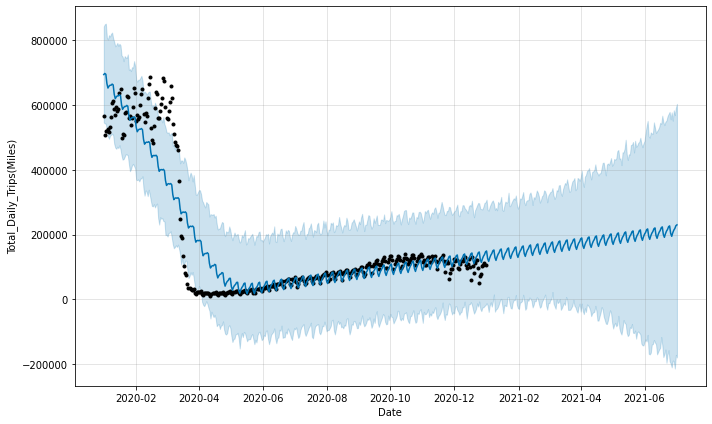

In [0]:
predict_fig = model.plot(forecast_pd, xlabel='Date', ylabel="Total_Daily_Trips(Miles)")
display(predict_fig)

In [0]:
forecast_result = forecast_pd[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [0]:
forecast_result = forecast_result.rename(columns={"ds": "TimeStamp", 'yhat': "forecast", 'yhat_lower': "Lower_bound", 'yhat_upper': "Upper_bound"})

In [0]:
forecast_result.tail(10)

Out[85]:

,TimeStamp,forecast,Lower_bound,Upper_bound
539,2021-06-23,215486.944396,-171153.848105,565187.297295
540,2021-06-24,224050.166001,-157202.715873,572361.249971
541,2021-06-25,226660.842339,-191687.189124,578905.697354
542,2021-06-26,203196.289593,-198231.552438,555902.002130
543,2021-06-27,194381.199480,-210392.620794,577380.581907
544,2021-06-28,205261.835796,-189324.816720,551611.033289
545,2021-06-29,213372.179540,-191519.469139,583776.421670
546,2021-06-30,218585.932633,-214090.579308,568764.230938
547,2021-07-01,227149.154238,-171824.290064,591417.733581
548,2021-07-02,229759.830576,-179827.133370,603672.803350
